In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import generate_data as gen_d

sns.set_style("white")
%matplotlib inline

# Exploration

In [2]:
df = pd.read_csv("blackjack.csv")

In [3]:
df.shape

(70000, 18)

In [4]:
df.describe()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_inital,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy
count,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,4.0,6.530743,14.557543,0.410043,0.560286,18.096514,0.178486,14.552786,0.572486,0.845100,19.892400,0.295114,0.543814,0.073129,0.383057,0.500000
std,0.0,3.153388,4.078590,0.491845,0.774488,4.351632,0.382924,4.082299,0.494721,0.899732,3.869239,0.456097,0.498080,0.260349,0.486136,0.500004
min,4.0,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.0,4.000000,12.000000,0.000000,0.000000,16.000000,0.000000,12.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.0,7.000000,15.000000,0.000000,0.000000,19.000000,0.000000,15.000000,1.000000,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.500000
75%,4.0,10.000000,18.000000,1.000000,1.000000,21.000000,0.000000,18.000000,1.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,4.0,10.000000,21.000000,1.000000,6.000000,26.000000,1.000000,21.000000,1.000000,6.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Repeated trials

In [108]:
# Simulate trials of 100 games
def sim_trial():
    ran = gen_d.gen_df(gen_d.gen_data(num_decks=4, df_size=50, strategy=0))
    ran = ran[["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]].sum()/len(ran)
    ran = pd.DataFrame(ran, ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]).T
    rec = gen_d.gen_df(gen_d.gen_data(num_decks=4, df_size=50, strategy=1))
    rec = rec[["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]].sum()/len(rec)
    rec = pd.DataFrame(rec, ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]).T
    sub = pd.concat([ran, rec])
    return sub

In [109]:
def n_trials(n=5000):
    trials = sim_trial()
    for _ in range(n-1):
        trials = pd.concat([trials, sim_trial()])
        
    return trials

In [110]:
trials = n_trials()

In [ ]:
# combine with older files
try:
    old_trials = pd.read_csv("trials.csv")
    trials = pd.concat([old_trials, trials])
except:
    pass

In [111]:
trials.to_csv("trials.csv", index=False)

In [112]:
trials.shape

(10000, 6)

In [113]:
trials.describe()

,dealer_busts,player_busts,player_loses,draw,player_wins,strategy
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.176852,0.295926,0.545842,0.071434,0.382724,0.500000
std,0.071539,0.182900,0.074857,0.037175,0.071408,0.500025
min,0.000000,0.000000,0.240000,0.000000,0.120000,0.000000
25%,0.120000,0.120000,0.500000,0.040000,0.340000,0.000000
50%,0.180000,0.260000,0.540000,0.060000,0.380000,0.500000
75%,0.220000,0.460000,0.600000,0.100000,0.420000,1.000000
max,0.440000,0.740000,0.840000,0.280000,0.660000,1.000000


## Difference between losing, drawing and winning

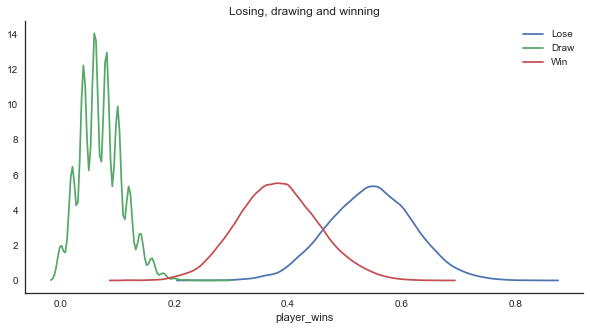

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_loses, hist=False, label="Lose");
sns.distplot(trials.draw, hist=False, label="Draw");
sns.distplot(trials.player_wins, hist=False, label="Win");
ax.set_title("Losing, drawing and winning");
sns.despine();

## Losses

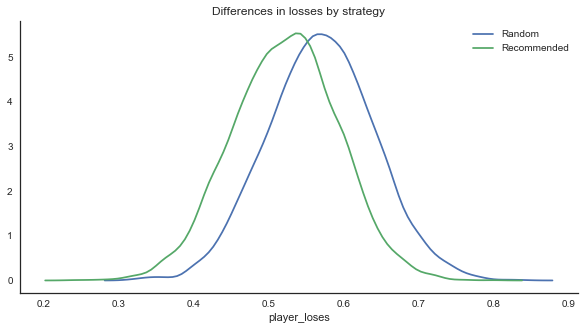

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_loses[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.player_loses[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in losses by strategy");
sns.despine();

## Draws

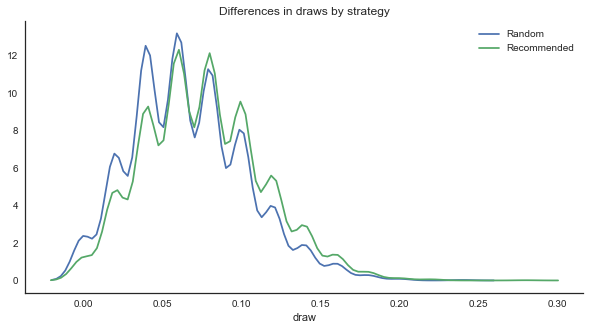

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.draw[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.draw[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in draws by strategy");
sns.despine();

## Wins

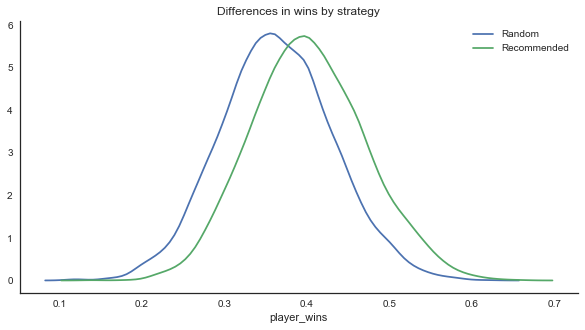

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_wins[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.player_wins[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in wins by strategy");
sns.despine();